![](img/330-banner.png)

# Lecture 16: Recommender Systems

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

## Imports

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


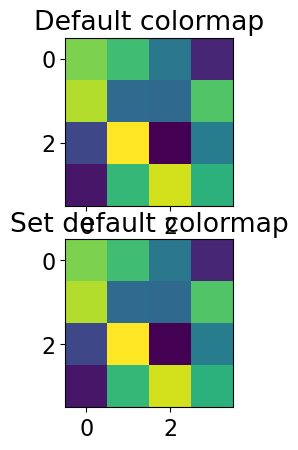

In [1]:
import os
import random
import sys
import time

import numpy as np
sys.path.append(os.path.join(os.path.abspath("."), "code"))

import matplotlib.pyplot as plt
from plotting_functions import *
from plotting_functions_unsup import *
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 16
import matplotlib.cm as cm

# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

## Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:

- State the problem of recommender systems. 
- Describe components of a utility matrix. 
- Create a utility matrix given ratings data. 
- Describe a common approach to evaluate recommender systems. 
- Implement some baseline approaches to complete the utility matrix. 
- Explain the idea of collaborative filtering. 
- Explain some serious consequences of recommendation systems. 

## Announcements

- Homework 6 is due Monday, November 13th at 11:59pm. 
- No classes or OH during the midterm break.

<br><br>

## ❓❓ Questions for you
**iClicker cloud join link: https://join.iclicker.com/SNBF**

What percentage of watch time on YouTube do you think comes from recommendations?
- (A) 50%
- (B) 60%
- (C) 20%
- (D) 90%

This [source](https://developers.google.com/machine-learning/recommendation/overview) says 60%. But the statistics might have changed now. 

## Recommender systems motivation

### What is a recommender system? 

- A recommender or a recommendation system **recommends** a particular product or service to users they are likely to consume. 

![](img/recommendation_system.png)

<!-- <img src="img/recommendation_system.png" alt="" height="900" width="900">  -->


### Example: Recommender Systems
- A client goes to Amazon to buy products. 
- Amazon has some information about the client. They also have information about other clients buying similar products. 
- What should they recommend to the client, so that they buy more products? 
- There's no "right" answer (no label). 
- The whole idea is to understand user behavior in order to recommend them products they are likely to consume. 

### Why should we care about recommendation systems? 

- Almost everything we buy or consume today is in some way or the other influenced by recommendation systems. 
    - Music (Spotify), videos (YouTube), news, books and products (Amazon), movies (Netflix), jokes, restaurants, dating , friends (Facebook), professional connections (Linkedin)
- Recommendation systems are at the core of the success of many companies. 
    - Amazon
    - [Netflix](https://help.netflix.com/en/node/100639)


### An example Capstone project: [QxMD](https://qxmd.com/)

- Present personalized journal article recommendations to health care professionals.   

### What kind of data we need to build recommendation systems? 

- **User ratings data** (most common)
- **Features related to items or users** 
- Customer purchase history data

### Main approaches

- Collaborative filtering 
    - "Unsupervised" learning 
    - We only have labels $y_{ij}$ (rating of user $i$ for item $j$). 
    - We learn features.  
- Content-based recommenders 
    - Supervised learning
    - Extract features $x_i$ of users and/or items and building a model to predict rating $y_i$ given $x_i$. 
    - Apply model to predict for new users/items. 
- Hybrid 
    - Combining collaborative filtering with content-based filtering
    

### The Netflix prize

![](img/netflix.png)

[Source](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

### The Netflix prize

- 100M ratings from 0.5M users on 18k movies.
- Grand prize was \$1M for first team to reduce squared error at least by 10%.
- Winning entry (and most entries) used collaborative filtering:
    - Methods that only looks at ratings, not features of movies/users.
- A simple collaborative filtering method that does really well:
   - Now adopted by many companies.

<br><br><br><br>

## Recommender systems problem 

### Problem formulation

- Most often the data for recommender systems come in as **ratings** for a set of items from a set of users. 
- We have two entities: $N$ **users** and $M$ **items**. 
- **Users** are consumers. 
- **Items** are the products or services offered.  
    - E.g., movies (Netflix), books (Amazon), songs (spotify), people (tinder)  
    
![](img/utility_matrix.png)

<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->


### Utility matrix 

- A **utility matrix** is the matrix that captures **interactions** between $N$ **users** and $M$ **items**. 
- The interaction may come in different forms: 
    - ratings, clicks, purchases

![](img/utility_matrix.png)

<!-- <img src="img/utility_mat.png" alt="" height="900" width="900">  -->

### Utility matrix

- Below is a toy utility matrix. Here $N$ = 6 and $M$ = 5.  
- Each entry $y_{ij}$ ($i^{th}$ row and $j^{th}$ column) denotes the rating given by the user $i$ to item $j$. 
- We represent users in terms of items and items in terms of users. 

![](img/utility_matrix.png)

<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->

### Sparsity of utility matrix

- The utility matrix is very sparse because usually users only interact with a few items. 
- For example: 
    - all Netflix users will have rated only a small percentage of content available on Netflix
    - all amazon clients will have rated only a small fraction of items among all items available on Amazon

### What do we predict? 
Given a utility matrix of $N$ users and $M$ items, **complete the utility matrix**. In other words, **predict missing values in the matrix**. 

![](img/utility_matrix.png)

<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->

- Once we have predicted ratings, we can recommend items to users they are likely to rate higher. 

### Example dataset: [Jester 1.7M jokes ratings dataset](https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset?select=jester_ratings.csv)

- We'll use a sample of [Jester 1.7M jokes ratings dataset](https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset) to demonstrate different recommendation systems. 

The dataset comes with two CSVs
- A CSV containing ratings (-10.0 to +10.0) of 150 jokes from 59,132 users. 
- A CSV containing joke IDs and the actual text of jokes. 

> Some jokes might be offensive. Please do not look too much into the actual text data if you are sensitive to such language.

- Recommendation systems are most effective when you have a large amount of data.
- But we are only taking a sample here for speed.

In [2]:
filename = "data/jester_ratings.csv"
ratings_full = pd.read_csv(filename)
ratings = ratings_full[ratings_full["userId"] <= 4000]

In [3]:
ratings.head()

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [4]:
user_key = "userId"
item_key = "jokeId"

### Dataset stats 

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141362 entries, 0 to 141361
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  141362 non-null  int64  
 1   jokeId  141362 non-null  int64  
 2   rating  141362 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.3 MB


In [6]:
def get_stats(ratings, item_key="jokeId", user_key="userId"):
    print("Number of ratings:", len(ratings))
    print("Average rating:  %0.3f" % (np.mean(ratings["rating"])))
    N = len(np.unique(ratings[user_key]))
    M = len(np.unique(ratings[item_key]))
    print("Number of users (N): %d" % N)
    print("Number of items (M): %d" % M)
    print("Fraction non-nan ratings: %0.3f" % (len(ratings) / (N * M)))
    return N, M


N, M = get_stats(ratings)

Number of ratings: 141362
Average rating:  1.200
Number of users (N): 3635
Number of items (M): 140
Fraction non-nan ratings: 0.278


### Creating utility matrix

- Let's construct utility matrix with `number of users` rows and `number of items` columns from the ratings data. 

> Note we are constructing a non-sparse matrix for demonstration purpose here. In real life it's recommended that you work with sparse matrices. 

In [7]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

In [8]:
def create_Y_from_ratings(
    data, N, M, user_mapper, item_mapper, user_key="userId", item_key="jokeId"
):  # Function to create a dense utility matrix
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

### Utility matrix for the example problem
- Rows represent users.
- Columns represent items (jokes in our case).
- Each cell gives the rating given by the user to the corresponding joke. 
- Users are features for jokes and jokes are features for users.
- We want to predict the missing entries. 

In [9]:
Y_mat = create_Y_from_ratings(ratings, N, M, user_mapper, item_mapper)
Y_mat.shape

(3635, 140)

In [10]:
pd.DataFrame(Y_mat)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-9.688,9.938,9.531,9.938,0.406,3.719,9.656,-2.688,-9.562,-9.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-9.844,-9.844,-7.219,-2.031,-9.938,-9.969,-9.875,-9.812,-9.781,-6.844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.812,-4.500,-4.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.906,4.750,-5.906,-0.406,-4.031,3.875,6.219,5.656,6.094,5.406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,NaN,-9.812,-0.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3631,NaN,-9.844,7.531,-9.719,-9.344,3.875,9.812,8.938,8.375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3632,NaN,-1.906,3.969,-2.312,-0.344,-8.844,4.188,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3633,NaN,-8.875,-9.156,-9.156,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br><br><br><br>

## Baseline Approaches


- Recall that our goal is to predict missing entries in the utility matrix. 

In [11]:
pd.DataFrame(Y_mat)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-9.688,9.938,9.531,9.938,0.406,3.719,9.656,-2.688,-9.562,-9.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-9.844,-9.844,-7.219,-2.031,-9.938,-9.969,-9.875,-9.812,-9.781,-6.844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.812,-4.500,-4.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.906,4.750,-5.906,-0.406,-4.031,3.875,6.219,5.656,6.094,5.406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,NaN,-9.812,-0.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3631,NaN,-9.844,7.531,-9.719,-9.344,3.875,9.812,8.938,8.375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3632,NaN,-1.906,3.969,-2.312,-0.344,-8.844,4.188,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3633,NaN,-8.875,-9.156,-9.156,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Evaluation

- We'll try a number of methods to do this. 
- Although there is no notion of "accurate" recommendations, we need a way to evaluate our predictions so that we'll be able to compare different methods.
- Although we are doing unsupervised learning, we'll split the data and evaluate our predictions as follows.  

### Data splitting 

- We split the ratings into train and validation sets. 
- It's easier to split the ratings data instead of splitting the utility matrix.
- Don't worry about `y`; we're not really going to use it.  

In [12]:
X = ratings.copy()
y = ratings[user_key]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape

((113089, 3), (28273, 3))

Now we will create utility matrices for train and validation splits. 

In [13]:
train_mat = create_Y_from_ratings(X_train, N, M, user_mapper, item_mapper)
valid_mat = create_Y_from_ratings(X_valid, N, M, user_mapper, item_mapper)

In [14]:
train_mat.shape, valid_mat.shape

((3635, 140), (3635, 140))

- `train_mat` has only ratings from the train set and `valid_mat` has only ratings from the valid set.
- During training we assume that we do not have access to some of the available ratings. We predict these ratings and evaluate them against ratings in the validation set. 

### Questions for you

- How do train and validation utility matrices differ? 
- Why are utility matrices for train and validation sets are of the same shape?
<br><br>

**Answer:**

- The training matrix `train_mat` is of shape N by M but only has ratings from `X_train` and all other ratings missing. 
- The validation matrix `valid_mat` is also of shape N by M but it only has ratings `X_valid` and all other ratings missing. 
- They have the same shape because both have the same number of users and items; that's how we have constructed them. 

### Evaluation

- Now that we have train and validation sets, how do we evaluate our predictions?
- You can calculate the error between actual ratings and predicted ratings with metrics of your choice. 
    - Most common ones are MSE or RMSE. 

- The `error` function below calculates RMSE and `evaluate` function prints train and validation RMSE.  

In [15]:
def error(X1, X2):
    """
    Returns the root mean squared error.
    """
    return np.sqrt(np.nanmean((X1 - X2) ** 2))


def evaluate(pred_X, train_X, valid_X, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_X, train_X)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_X, valid_X)))

<br><br>

### Baselines

Let's first try some simple approaches to predict missing entries. 

1. Global average baseline
2. [$k$-Nearest Neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)    
    

### Global average baseline

- Let's examine RMSE of the global average baseline. 
- In this baseline we predict everything as the global average rating

In [16]:
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
1,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
2,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
3,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
4,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741


In [17]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 5.75
Global average valid RMSE: 5.77


### [$k$-nearest neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

- Can we try $k$-nearest neighbours type imputation? 
- Impute missing values using the mean value from $k$ nearest neighbours found in the training set. 
- Calculate distances between examples using features where neither value is missing. 

![](img/utility_matrix.png)

<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->

In [18]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
train_mat_imp = imputer.fit_transform(train_mat)

In [19]:
pd.DataFrame(train_mat_imp)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-5.9406,-9.2810,-9.2810,-6.7810,0.8750,-9.6560,-9.0310,-7.4690,-8.7190,-9.1560,...,-4.5311,1.8968,0.6905,-3.1218,1.2843,-2.6063,-0.1812,-1.3937,1.7625,-0.4092
1,2.3405,9.9380,9.5310,9.9380,0.4060,3.7190,9.6560,-2.6880,4.3438,-9.1250,...,2.2437,3.1719,5.0251,5.1812,8.2407,5.9311,5.8375,6.3812,1.1687,6.2532
2,-9.8440,-3.5750,-7.2190,-2.0310,-9.9380,-9.9690,-9.8750,-9.8120,-9.7810,-6.8440,...,-4.4186,-3.1156,-1.5655,-5.6250,0.3720,-4.0439,-6.0500,-5.5563,-5.4125,-5.5874
3,-5.8120,-2.4624,-4.9060,-2.7781,-0.0532,-3.8594,1.7031,-0.3687,1.8469,0.0593,...,-2.0344,2.1469,2.8875,1.6845,1.2437,-0.0156,1.2595,3.8219,3.1971,5.0249
4,1.3157,4.7500,1.8658,-0.4060,1.7937,3.8750,6.2190,1.9220,6.0940,5.4060,...,-0.2844,1.1313,4.0157,3.0344,4.0406,0.5218,4.3594,4.0968,3.9250,3.9657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,-0.7750,-9.8120,-0.0620,-2.8218,-4.1470,-4.8281,2.2718,-2.8782,-1.0125,0.0688,...,-6.6844,3.0531,2.8687,1.5281,4.5002,-0.1878,2.0031,4.0908,2.3563,5.0406
3631,2.5188,-5.0625,-0.4001,-9.7190,-9.3440,-1.6408,-4.1187,8.9380,8.3750,-0.9314,...,-4.0344,7.9155,3.4282,4.2968,6.7968,7.3999,1.8500,5.8219,5.1812,2.8437
3632,0.1749,-1.9060,3.9690,-1.3844,-0.3440,-8.8440,4.1880,-1.5564,5.0593,0.3343,...,-4.0126,2.8344,2.4499,2.9312,2.3750,-0.4062,1.4375,3.9750,-1.2220,2.8375
3633,-4.5937,-6.4907,-6.1594,-9.1560,-7.1437,-6.5406,2.2031,-1.7782,-3.7406,-0.6406,...,-4.6938,4.8061,4.9968,-0.1626,2.4187,-0.7750,4.6781,1.7658,0.4595,0.1843


In [20]:
evaluate(train_mat_imp, train_mat, valid_mat, model_name="KNN imputer")

KNN imputer train RMSE: 0.00
KNN imputer valid RMSE: 4.79


### Finding [nearest neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html)

- We can look at nearest neighbours of a query item. 
- Here our columns are jokes, and users are features for jokes, and we'll have to find nearest neighbours of columns vectors. 

In [21]:
pd.DataFrame(train_mat_imp)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-5.9406,-9.2810,-9.2810,-6.7810,0.8750,-9.6560,-9.0310,-7.4690,-8.7190,-9.1560,...,-4.5311,1.8968,0.6905,-3.1218,1.2843,-2.6063,-0.1812,-1.3937,1.7625,-0.4092
1,2.3405,9.9380,9.5310,9.9380,0.4060,3.7190,9.6560,-2.6880,4.3438,-9.1250,...,2.2437,3.1719,5.0251,5.1812,8.2407,5.9311,5.8375,6.3812,1.1687,6.2532
2,-9.8440,-3.5750,-7.2190,-2.0310,-9.9380,-9.9690,-9.8750,-9.8120,-9.7810,-6.8440,...,-4.4186,-3.1156,-1.5655,-5.6250,0.3720,-4.0439,-6.0500,-5.5563,-5.4125,-5.5874
3,-5.8120,-2.4624,-4.9060,-2.7781,-0.0532,-3.8594,1.7031,-0.3687,1.8469,0.0593,...,-2.0344,2.1469,2.8875,1.6845,1.2437,-0.0156,1.2595,3.8219,3.1971,5.0249
4,1.3157,4.7500,1.8658,-0.4060,1.7937,3.8750,6.2190,1.9220,6.0940,5.4060,...,-0.2844,1.1313,4.0157,3.0344,4.0406,0.5218,4.3594,4.0968,3.9250,3.9657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,-0.7750,-9.8120,-0.0620,-2.8218,-4.1470,-4.8281,2.2718,-2.8782,-1.0125,0.0688,...,-6.6844,3.0531,2.8687,1.5281,4.5002,-0.1878,2.0031,4.0908,2.3563,5.0406
3631,2.5188,-5.0625,-0.4001,-9.7190,-9.3440,-1.6408,-4.1187,8.9380,8.3750,-0.9314,...,-4.0344,7.9155,3.4282,4.2968,6.7968,7.3999,1.8500,5.8219,5.1812,2.8437
3632,0.1749,-1.9060,3.9690,-1.3844,-0.3440,-8.8440,4.1880,-1.5564,5.0593,0.3343,...,-4.0126,2.8344,2.4499,2.9312,2.3750,-0.4062,1.4375,3.9750,-1.2220,2.8375
3633,-4.5937,-6.4907,-6.1594,-9.1560,-7.1437,-6.5406,2.2031,-1.7782,-3.7406,-0.6406,...,-4.6938,4.8061,4.9968,-0.1626,2.4187,-0.7750,4.6781,1.7658,0.4595,0.1843


### (Optional) $k$-nearest neighbours on a query joke
- Let's transpose the matrix.  

In [22]:
item_user_mat = train_mat_imp.T

In [23]:
jokes_df = pd.read_csv("data/jester_items.csv")
jokes_df.head()

,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I have bad news for you.You have\ncancer and Alzheimer's disease"". \nThe man replies ""Well,thank God I don't have cancer!""\n"
1,2,"This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n""What could they possibly have said to make you move out?"" \n\n""They told me that you were a pedophile."" \n\nHe replied, ""That's an awfully big word for a ten year old."" \n"
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA. The front row at a Willie Nelson Concert.\n
3,4,Q. What's the difference between a man and a toilet? \n\nA. A toilet doesn't follow you around after you use it.\n
4,5,"Q.\tWhat's O. J. Simpson's Internet address? \nA.\tSlash, slash, backslash, slash, slash, escape.\n"


In [24]:
id_joke_map = dict(zip(jokes_df.jokeId, jokes_df.jokeText))

In [25]:
from sklearn.neighbors import NearestNeighbors


def get_topk_recommendations(X, query_ind=0, metric="cosine", k=5):
    query_idx = item_inverse_mapper[query_ind]
    model = NearestNeighbors(n_neighbors=k, metric="cosine")
    model.fit(X)
    neigh_ind = model.kneighbors([X[query_ind]], k, return_distance=False).flatten()
    neigh_ind = np.delete(neigh_ind, np.where(query_ind == query_ind))
    recs = [id_joke_map[item_inverse_mapper[i]] for i in neigh_ind]
    print("Query joke: ", id_joke_map[query_idx])

    return pd.DataFrame(data=recs, columns=["top recommendations"])


get_topk_recommendations(item_user_mat, query_ind=8, metric="cosine", k=5)

Query joke:  Q: If a person who speaks three languages is called "tri-lingual," and
a person who speaks two languages is called "bi-lingual," what do call
a person who only speaks one language?

A: American! 



,top recommendations
0,"Q: What is the difference between George Washington, Richard Nixon,\nand Bill Clinton?\n\nA: Washington couldn't tell a lie, Nixon couldn't tell the truth, and\nClinton doesn't know the difference.\n"
1,"A man in a hot air balloon realized he was lost. He reduced altitude and spotted a woman below. He descended a bit more and shouted, ""Excuse me, can you help me? I promised a friend I would meet him an hour ago, but I don't know where I am."" The woman below replied, ""You are in a hot air balloon hovering approximately 30 feet above the ground. You are between 40 and 41 degrees north latitude and between 59 and 60 degrees west longitude."" ""You must be an engineer,"" said the balloonist. ""I am,"" replied the woman. ""How did you know?"" ""Well,"" answered the balloonist, ""everything you told me is technically correct, but I have no idea what to make of your information, and the fact is, I am still lost. Frankly, you've not been much help so far."" The woman below responded, ""You must be in management."" ""I am,"" replied the balloonist, ""but how did you know?"" ""Well,"" said the woman, ""you don't know where you are or where you are going. You have risen to where you are due to a large quantity of hot air. You made a promise that you have no idea how to keep, and you expect people beneath you to solve your problems. The fact is, you are in exactly the same position you were in before we met, but now, somehow, it's my fault!"""
2,If pro- is the opposite of con- then congress must be the opposite\nof progress.\n
3,"Arnold Swartzeneger and Sylvester Stallone are making a movie about\nthe lives of the great composers. \nStallone says ""I want to be Mozart."" \nSwartzeneger says: ""In that case... I'll be Bach.""\n"


**Question**
- Instead of imputation, what would be the consequences if we replace `nan` with zeros so that we can calculate distances between vectors? 

<br><br>
**Answer**

It's not a good idea replace ratings with 0, because 0 can be an actual rating value in our case. 

### What to do with predictions? 
- Once you have predictions, you can sort them based on ratings and recommend items with highest ratings.  

## Break (5 min)

![](img/eva-coffee.png)

## Collaborative filtering 

### Collaborative filtering 
- One of the most popular approach for recommendation systems. 
- Approach used by the winning entry (and most of the entries) in the Netflix competition. 
- An unsupervised approach
    - Only uses the user-item interactions given in the ratings matrix. 
- **Intuition**
    - We may have similar users and similar items which can help us predict missing entries. 
    - Leverage social information to provide recommendations. 

### Problem 

- Given a utility matrix with many missing entries, how can we predict missing ratings?  

$$
\begin{bmatrix} 
? & ? & \checkmark  & ? & \checkmark\\
\checkmark & ? & ?  & ? & ?\\
? & \checkmark & \checkmark  & ? & \checkmark\\
? & ? & ?  & ? & ?\\
? & ? & ? & \checkmark & ?\\
? & \checkmark & \checkmark  & ? & \checkmark
\end{bmatrix}
$$

> Note: rating prediction $\neq$ Classification or regression 

### Classification or regression

- We have $X$ and targets for some rows in $X$. 
- We want to predict the last column (target column).  

$$
\begin{bmatrix} 
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\end{bmatrix}
$$

### Rating prediction 

- Ratings data has many missing values in the utility matrix. There is no special target column. We want to predict the missing entries in the matrix. 
- Since our goal is to **predict** ratings, usually the utility matrix is referred to as $Y$ matrix. 

$$
\begin{bmatrix} 
? & ? & \checkmark  & ? & \checkmark\\
\checkmark & ? & ?  & ? & ?\\
? & \checkmark & \checkmark  & ? & \checkmark\\
? & ? & ?  & ? & ?\\
? & ? & ? & \checkmark & ?\\
? & \checkmark & \checkmark  & ? & \checkmark
\end{bmatrix}
$$


<br><br>

- We don't have sufficient background to understand how collaborative filtering works under-the-hood.
- Let's look at an example to understand this at a high level. 

### Toy movie recommendation example

- It's a bit hard to create a toy example with jokes. 
- So let's walk through a movie recommendation toy example. 
- The toy data below contains movie ratings for seven movies given by 4 users. 
- Do you see any pattern here?

![](img/toy-movie.png)

- In this toy example, we see clear groups of movies and users.
    - For movies: Children movies and documentaries 
    - For users: Children movie lovers and documentary lovers  
- How can we identify such latent features?
    - Some tools can detect patterns or 'latent features'. Once these latent features for users and items are identified, you can infer the missing values in the utility matrix. Only a high-level understanding is expected of you here, as the details are beyond the scope of this course.  
<br><br>
![](img/toy-movie-pattern.png)

<br><br>

### Rating prediction using the surprise package

- We'll be using a package called [Surprise](https://surprise.readthedocs.io/en/stable/index.html). 
- The collaborative filtering algorithm we use in this package is called `SVD`. 

```
pip install scikit-surprise
```

Let's try it out on our Jester dataset utility matrix.  

In [26]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy

In [27]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)  # Load the data

# I'm being sloppy here. Probably there is a way to create validset from our already split data.
trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)  # Split the data

In [28]:
k = 10
algo = SVD(n_factors=k, random_state=42)
algo.fit(trainset)
svd_preds = algo.test(validset)
accuracy.rmse(svd_preds, verbose=True)

RMSE: 5.2893


5.28926338380112

- No big improvement over the global baseline (RMSE=5.77). 
- Probably because we are only considering a sample. 

### (Optional) Cross-validation for recommender systems

- We can also carry out cross-validation and grid search with this package. 
- Let's look at an example of cross-validation. 

In [29]:
from surprise.model_selection import cross_validate

pd.DataFrame(cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    5.2716  5.2838  5.2888  5.2999  5.2783  5.2845  0.0096  
MAE (testset)     4.1961  4.2023  4.2105  4.2110  4.1939  4.2028  0.0071  
Fit time          0.23    0.24    0.22    0.22    0.23    0.23    0.01    
Test time         0.09    0.09    0.08    0.15    0.08    0.10    0.02    


,test_rmse,test_mae,fit_time,test_time
0,5.271581,4.196101,0.230997,0.087165
1,5.283764,4.202333,0.239803,0.087761
2,5.288806,4.210477,0.215266,0.084854
3,5.299871,4.210979,0.217354,0.145886
4,5.278311,4.193868,0.227576,0.084599


- Jester dataset is available as one of the built-in datasets in this package and you can load it as follows and run cross-validation as follows. 

In [30]:
data = Dataset.load_builtin("jester")

pd.DataFrame(cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.5747  4.5823  4.5770  4.5848  4.5971  4.5832  0.0078  
MAE (testset)     3.3164  3.3229  3.3154  3.3227  3.3316  3.3218  0.0058  
Fit time          4.54    4.27    4.48    4.40    4.34    4.41    0.10    
Test time         2.30    2.74    2.82    2.21    2.24    2.46    0.26    


,test_rmse,test_mae,fit_time,test_time
0,4.574714,3.316417,4.543218,2.300389
1,4.582342,3.322949,4.268685,2.737277
2,4.577024,3.315384,4.480588,2.818060
3,4.584840,3.322710,4.395639,2.210944
4,4.597096,3.331636,4.339923,2.237323


<br><br><br><br>

## Content-based filtering

### What is content-based filtering? 

- Supervised machine learning approach
- In collaborative filtering we assumed that we only have ratings data. 
- Usually there is some information on items and users available. 
- Examples
    - Netflix can describe movies as action, romance, comedy, documentaries. 
    - Amazon could describe books according to topics: math, languages, history. 
    - Tinder could describe people according to age, location, employment.
- Can we use this information to predict ratings in the utility matrix?   
    - Yes!

### Item and user features

- In collaborative filtering we assumed that we only have ratings data. 
- Usually there is some information available on items and users. 
- Examples
    - Netflix can describe movies as action, romance, comedy, documentaries. 
    - Amazon could describe books according to topics: math, languages, history. 
    - Tinder could describe people according to age, location, employment.
- Can we use this information to predict ratings in the utility matrix?   
    - Yes!

### Toy example: Movie recommendation

- Let's consider movie recommendation problem with the following toy data.

### Ratings data

In [31]:
toy_ratings = pd.read_csv("data/toy_ratings.csv")
toy_ratings

,user_id,movie_id,rating
0,Sam,Lion King,4
1,Sam,Jerry Maguire,4
2,Sam,Roman Holidays,5
3,Sam,Downfall,1
4,Eva,Titanic,2
5,Eva,Jerry Maguire,1
6,Eva,Inception,4
7,Eva,Man on Wire,5
8,Eva,The Social Dilemma,5
9,Pat,Titanic,3


In [32]:
N = len(np.unique(toy_ratings["user_id"]))
M = len(np.unique(toy_ratings["movie_id"]))
print("Number of users (N)                : %d" % N)
print("Number of movies (M)               : %d" % M)

Number of users (N)                : 4
Number of movies (M)               : 12


In [33]:
user_key = "user_id"
item_key = "movie_id"

In [34]:
user_mapper = dict(zip(np.unique(toy_ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(toy_ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(toy_ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(toy_ratings[item_key])))

### Utility matrix

Let's create a dense utility matrix for our toy dataset. 

In [35]:
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

### Utility matrix

In [36]:
Y = create_Y_from_ratings(toy_ratings, N, M)
utility_mat = pd.DataFrame(Y, columns=item_mapper.keys(), index=user_mapper.keys())
utility_mat

,A Beautiful Mind,Bambi,Cast Away,Downfall,Inception,Jerry Maguire,Lion King,Malcolm x,Man on Wire,Roman Holidays,The Social Dilemma,Titanic
Eva,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,5.0,NaN,5.0,2.0
Jim,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,NaN,5.0,2.0
Pat,3.0,4.0,3.0,2.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0
Sam,NaN,NaN,NaN,1.0,NaN,4.0,4.0,NaN,NaN,5.0,NaN,NaN


In [37]:
avg = np.nanmean(Y)

**Goal**: Predict missing entries in the utility matrix. 

In [38]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy

Let's predict ratings with collaborative filtering.

In [39]:
reader = Reader()
data = Dataset.load_from_df(toy_ratings, reader)  # Load the data

trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.01, random_state=42
)  # Split the data

In [40]:
k = 2
algo = SVD(n_factors=k, random_state=42)
algo.fit(trainset)
preds = algo.test(trainset.build_testset())

In [41]:
from collections import defaultdict

rating_preds = defaultdict(list)
for uid, iid, true_r, est, _ in preds:
    rating_preds[uid].append((iid, est))

In [42]:
rating_preds

defaultdict(list,
            {'Sam': [('Lion King', 3.5442874862516582),
              ('Jerry Maguire', 3.471958396420975),
              ('Downfall', 3.141157981632877),
              ('Roman Holidays', 3.6555436348053982)],
             'Jim': [('Lion King', 3.6494404051925047),
              ('The Social Dilemma', 3.8739407581035588),
              ('Titanic', 3.295718235231984),
              ('Man on Wire', 3.8839492577938532),
              ('Malcolm x', 3.6435176323135128)],
             'Pat': [('A Beautiful Mind', 3.4463313322323263),
              ('Bambi', 3.540418795140043),
              ('Jerry Maguire', 3.4582870107738803),
              ('Titanic', 3.1872411557123517),
              ('Cast Away', 3.4442142132704827),
              ('Lion King', 3.5286392016604875),
              ('Downfall', 3.133747883605952)],
             'Eva': [('The Social Dilemma', 3.6665140635371194),
              ('Jerry Maguire', 3.3423360343482957),
              ('Titanic', 3.113324069881

### Movie features

- Suppose we also have movie features. 

In [43]:
movie_feats_df = pd.read_csv("data/toy_movie_feats.csv", index_col=0)
movie_feats_df

,Action,Romance,Drama,Comedy,Children,Documentary
A Beautiful Mind,0,1,1,0,0,0
Bambi,0,0,1,0,1,0
Cast Away,0,1,1,0,0,0
Downfall,0,0,0,0,0,1
Inception,1,0,1,0,0,0
Jerry Maguire,0,1,1,1,0,0
Lion King,0,0,1,0,1,0
Malcolm x,0,0,0,0,0,1
Man on Wire,0,0,0,0,0,1
Roman Holidays,0,1,1,1,0,0


In [44]:
Z = movie_feats_df.to_numpy()
Z.shape

(12, 6)

- How can we use these features to predict missing ratings? 

### Overall idea

- Using the ratings data and movie features, we'll build **profiles for different users**. 
- Let's consider an example user **Pat**. 

### Pat's ratings

- We don't know anything about Pat but we know her ratings to movies. 

In [45]:
utility_mat.loc["Pat"]

A Beautiful Mind      3.0
Bambi                 4.0
Cast Away             3.0
Downfall              2.0
Inception            NaN 
Jerry Maguire         5.0
Lion King             4.0
Malcolm x            NaN 
Man on Wire          NaN 
Roman Holidays       NaN 
The Social Dilemma   NaN 
Titanic               3.0
Name: Pat, dtype: float64

- We also know about movies and their features. 
- If Pat gave a high rating to _Lion King_, it means that she liked the features of the movie. 

In [46]:
movie_feats_df.loc["Lion King"]

Action         0
Romance        0
Drama          1
Comedy         0
Children       1
Documentary    0
Name: Lion King, dtype: int64

### Supervised approach to rating prediction 

- We treat ratings prediction problem as a set of regression problems. 
- Given movie information, we create user profile for each user.
- Build regression model for each user and learn regression weights for each user. 

- We build a profile for users based on 
    - the movies they have watched
    - their rating for the movies
    - the features of the movies
- We train a personalized regression model for each user using this information. 


### Supervised approach to rating prediction 

For each user $i$ create a user profile as follows. 

- Consider all movies rated by $i$ and create `X` and `y` for the user: 
    - Each row in `X` contains the movie features of movie $j$ rated by $i$. 
    - Each value in `y` is the corresponding rating given to the movie $j$ by user $i$. 
- Fit a regression model using `X` and `y`. 
- Apply the model to predict ratings for new items! 

### Let's build user profiles 

- Build `X` and `y` for all users. 

In [47]:
from collections import defaultdict


def get_lr_data_per_user(ratings_df, d):
    lr_y = defaultdict(list)
    lr_X = defaultdict(list)
    lr_items = defaultdict(list)

    for index, val in ratings_df.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        lr_X[n].append(Z[m])
        lr_y[n].append(val["rating"])
        lr_items[n].append(m)

    for n in lr_X:
        lr_X[n] = np.array(lr_X[n])
        lr_y[n] = np.array(lr_y[n])

    return lr_X, lr_y, lr_items

In [48]:
d = movie_feats_df.shape[1]
X_train_usr, y_train_usr, rated_items = get_lr_data_per_user(toy_ratings, d)

- What's going is be shape of each `X` and `y`?

### Examine user profiles 

- Let's examine some user profiles. 

In [49]:
def get_user_profile(user_name):
    X = X_train_usr[user_mapper[user_name]]
    y = y_train_usr[user_mapper[user_name]]
    items = rated_items[user_mapper[user_name]]
    movie_names = [item_inverse_mapper[item] for item in items]
    print("Profile for user: ", user_name)
    profile_df = pd.DataFrame(X, columns=movie_feats_df.columns, index=movie_names)
    profile_df["ratings"] = y
    return profile_df

### Pat's profile

In [50]:
get_user_profile("Pat")

Profile for user:  Pat


,Action,Romance,Drama,Comedy,Children,Documentary,ratings
Titanic,0,1,1,0,0,0,3
Lion King,0,0,1,0,1,0,4
Bambi,0,0,1,0,1,0,4
Cast Away,0,1,1,0,0,0,3
Jerry Maguire,0,1,1,1,0,0,5
Downfall,0,0,0,0,0,1,2
A Beautiful Mind,0,1,1,0,0,0,3


- Pat seems to like Children's movies and movies with Comedy. 
- Seems like she's not so much into romantic movies.  


### Eva's profile

In [51]:
get_user_profile("Eva")

Profile for user:  Eva


,Action,Romance,Drama,Comedy,Children,Documentary,ratings
Titanic,0,1,1,0,0,0,2
Jerry Maguire,0,1,1,1,0,0,1
Inception,1,0,1,0,0,0,4
Man on Wire,0,0,0,0,0,1,5
The Social Dilemma,0,0,0,0,0,1,5


- Eva hasn't rated many movies. There are not many rows. 
- Eva seems to like documentaries and action movies. 
- Seems like she's not so much into romantic movies.  

### Regression models for users

In [52]:
from sklearn.linear_model import Ridge


def train_for_usr(user_name, model=Ridge()):
    X = X_train_usr[user_mapper[user_name]]
    y = y_train_usr[user_mapper[user_name]]
    model.fit(X, y)
    return model


def predict_for_usr(model, movie_names):
    feat_vecs = movie_feats_df.loc[movie_names].values
    preds = model.predict(feat_vecs)
    return preds

### Regression model for Pat 

- What are the regression weights learned for Pat? 

In [53]:
user_name = "Pat"
pat_model = train_for_usr(user_name)
col = "Coefficients for %s" % user_name
pd.DataFrame(pat_model.coef_, index=movie_feats_df.columns, columns=[col])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,Coefficients for Pat
Action,0.000000
Romance,-0.020833
Drama,0.437500
Comedy,0.854167
Children,0.458333
Documentary,-0.437500


### Predictions for Pat
- How would Pat rate some movies she hasn't seen? 

In [54]:
movies_to_pred = ["Roman Holidays", "Malcolm x"]
pred_df = movie_feats_df.loc[movies_to_pred]
pred_df

,Action,Romance,Drama,Comedy,Children,Documentary
Roman Holidays,0,1,1,1,0,0
Malcolm x,0,0,0,0,0,1


In [55]:
user_name = "Pat"
preds = predict_for_usr(pat_model, movies_to_pred)
pred_df[user_name + "'s predicted ratings"] = preds
pred_df

,Action,Romance,Drama,Comedy,Children,Documentary,Pat's predicted ratings
Roman Holidays,0,1,1,1,0,0,4.145833
Malcolm x,0,0,0,0,0,1,2.437500


### Regression model for Eva 

- What are the regression weights learned for Eva? 

In [56]:
user_name = "Eva"
eva_model = train_for_usr(user_name)
col = "Coefficients for %s" % user_name
pd.DataFrame(eva_model.coef_, index=movie_feats_df.columns, columns=[col])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,Coefficients for Eva
Action,0.333333
Romance,-1.000000
Drama,-0.666667
Comedy,-0.666667
Children,0.000000
Documentary,0.666667


### Predictions for Eva

- What are the predicted ratings for Eva for a list of movies?

In [57]:
user_name = "Eva"
preds = predict_for_usr(eva_model, movies_to_pred)
pred_df[user_name + "'s predicted ratings"] = preds
pred_df

,Action,Romance,Drama,Comedy,Children,Documentary,Pat's predicted ratings,Eva's predicted ratings
Roman Holidays,0,1,1,1,0,0,4.145833,1.666667
Malcolm x,0,0,0,0,0,1,2.437500,4.666667


### Completing the utility matrix with content-based filtering

Here is the original utility matrix.  

In [58]:
utility_mat

,A Beautiful Mind,Bambi,Cast Away,Downfall,Inception,Jerry Maguire,Lion King,Malcolm x,Man on Wire,Roman Holidays,The Social Dilemma,Titanic
Eva,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,5.0,NaN,5.0,2.0
Jim,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,NaN,5.0,2.0
Pat,3.0,4.0,3.0,2.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0
Sam,NaN,NaN,NaN,1.0,NaN,4.0,4.0,NaN,NaN,5.0,NaN,NaN


- Using predictions per user, we can fill in missing entries in the utility matrix. 

In [59]:
from sklearn.linear_model import Ridge

models = dict()
pred_lin_reg = np.zeros((N, M))

for n in range(N):
    models[n] = Ridge()
    models[n].fit(X_train_usr[n], y_train_usr[n])
    pred_lin_reg[n] = models[n].predict(Z)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [60]:
pd.DataFrame(pred_lin_reg, columns=item_mapper.keys(), index=user_mapper.keys())

,A Beautiful Mind,Bambi,Cast Away,Downfall,Inception,Jerry Maguire,Lion King,Malcolm x,Man on Wire,Roman Holidays,The Social Dilemma,Titanic
Eva,2.333333,3.333333,2.333333,4.666667,3.666667,1.666667,3.333333,4.666667,4.666667,1.666667,4.666667,2.333333
Jim,2.575000,3.075000,2.575000,4.450000,3.150000,2.575000,3.075000,4.450000,4.450000,2.575000,4.450000,2.575000
Pat,3.291667,3.770833,3.291667,2.437500,3.312500,4.145833,3.770833,2.437500,2.437500,4.145833,2.437500,3.291667
Sam,3.810811,3.675676,3.810811,1.783784,3.351351,4.270270,3.675676,1.783784,1.783784,4.270270,1.783784,3.810811


### More comments on content-based filtering

- The feature matrix for movies can contain different types of features.
    - Example: Plot of the movie (text features), actors (categorical features), year of the movie, budget and revenue of the movie (numerical features). 
    - You'll apply our usual preprocessing techniques to these features. 
- If you have enough data, you could also carry out hyperparameter tuning with cross-validation for each model.
- Finally, although we have been talking about linear models above, you can use any regression model of your choice. 

### Advantages of content-based filtering 

- We don't need many users to provide ratings for an item. 
- Each user is modeled separately, so you might be able to capture uniqueness of taste. 
- Since you can obtain the features of the items, you can immediately recommend new items. 
    - This would not have been possible with collaborative filtering. 
- Recommendations are interpretable.
    - You can explain to the user why you are recommending an item because you have learned weights. 
    

### Disadvantages of content-based filtering 

- Feature acquisition and feature engineering
    - What features should we use to explain the difference in ratings? 
    - Obtaining those features for each item might be very expensive. 
- Less diversity: hardly recommend an item outside the user's profile. 
- Cold start: When a new user shows up, you don't have any information about them.

### Hybrid filtering

- Combining advantages of collaborative filtering and content-based filtering

<br><br><br><br>

## Final comments and summary <a name="1"></a>

### Formulating the problem of recommender systems 

- We are given ratings data. 
- We use this data to create **utility matrix** which encodes interactions between users and items. 
- The utility matrix has many missing entries. 
- We defined recommendation systems problem as **matrix completion problem**. 

### What did we cover? 

- There is a big world of recommendation systems out there. We talked about some basic traditional approaches to recommender systems. 
    - collaborative filtering (high level)
    - content-based filtering 

If you want to know more advanced approaches to recommender systems, watch this 4-hour summer school tutorial by Xavier Amatriain, Research/Engineering Director @ Netflix.  

- [Part1](https://www.youtube.com/watch?v=bLhq63ygoU8)
- [Part2](https://www.youtube.com/watch?v=mRToFXlNBpQ)


### Evaluation 

- We split the data similar to supervised systems. 
- We evaluate recommendation systems using traditional regression metrics such as MSE or RMSE. 
- But real evaluation of recommender system can be very tricky because there is no ground truth. 
- We have been using RMSE due to the lack of a better measure.  
- What we actually want to measure is the interest that our user has in the recommended items. 

### Beyond error rate in recommendation systems 

- If a system gives the best RMSE it doesn't necessarily mean that it's going to give best recommendations. 
- In recommendation systems we do not have ground truth.
- Just training your model and evaluating it offline is not ideal. 
- Other aspects such as simplicity, interpretation, code maintainability are equally (if not more) important than best validation error. 
- Winning system of Netflix Challenge was never adopted.
    - Big mess of ensembles was not really maintainable 
- There are other considerations. 

### Other issues important in recommender systems

### Are these good recommendations? 

You are looking for water shoes and at the moment you are looking at [VIFUUR Water Sports Shoes](https://www.amazon.ca/VIFUUR-Barefoot-Quick-Dry-Blue-38-39/dp/B0753DL15Y), are these good recommendations? 

![](img/reco-diversity.png)


Now suppose you've recently bought VIFUUR Water Sports Shoes and rated them highly. Are these good recommendations now? 
- Not really. Even though you really liked them you don't need them anymore. You want some non-Water Sports Shoes recommendations.
- **Diversity** is about how different are the recommendations. 
    - Another example: Even if you really really like Star Wars, you might want non-Star-Wars suggestions.    
- But be careful. We need a balance here. 

### Are these good recommendations? 

![](img/freshness.png)

- Some of these books don't have many ratings but it might be a good idea to recommend "fresh" things. 
- **Freshness**: people tend to get more excited about new/surprising things.    

- But again you need a balance here. What would happen if you keep surprising the user all the time? 
- There might be **trust** issues. 
- Another aspect of trust is explaining your recommendation, i.e., telling the user why you made a recommendation. This gives the user an opportunity to understand why your recommendations could be interesting to them.   
    
![](img/recommendation-explanation.png)    

[Source](https://sudonull.com/post/65548-10-lessons-of-the-Quora-recommendation-system-Retail-Rocket-Blog)

**Persistence**: how long should recommendations last?
- If you keep not clicking on a recommendation, should it remain a recommendation?

**Social recommendation**: what did your friends watch?
- Many recommenders	are	now	connected to social	networks.
- "Login using you Facebook	account".
- Often, people	like similar movies	to their friends.
- If we get a new user, then recommendations are based on friend's preferences. 

### Types of data 

- Explicit data: ratings, thumbs up, etc. 
- Implicit data: collected from the users' behaviour (e.g., mouse clicks, purchases, time spent doing something)
- Trust implicit data that costs something, like time or even money. 
    - this makes it harder to fraud

### Some thoughts on recommendation systems  
- Be mindful of the consequences of recommendation systems. 
    - Recommendation systems can have terrible consequences. 
- Companies such as Amazon,  Netflix, Facebook, Google (YouTube), which extensively use recommendation systems, are profit-driven and so they design these systems to maximize user attention; their focus is not necessarily human well-being. 
- There are tons of news and research articles on serious consequences of recommendation systems.  

### Some thoughts on recommendation systems  

- Some weird stories which got media attention.   
[How Target Figured Out A Teen Girl Was Pregnant Before Her Father Did](https://www.forbes.com/sites/kashmirhill/2012/02/16/how-target-figured-out-a-teen-girl-was-pregnant-before-her-father-did/?sh=3171af136668)
- More serious consequences are in political contexts. 
    - [Facebook Admits It Was Used to Incite Violence in Myanmar](https://www.nytimes.com/2018/11/06/technology/myanmar-facebook.html)
    - [YouTube Extremism and the Long Tail](https://www.theatlantic.com/politics/archive/2018/03/youtube-extremism-and-the-long-tail/555350/)    

### My advice

- Ask hard and uncomfortable questions to yourself (and to your employer if possible) before implementing and deploying such systems.  



### Resources 

- [Collaborative filtering for recommendation systems in Python, by N. Hug](https://www.youtube.com/watch?v=z0dx-YckFko)
- [An interesting talk: The paradox of choice](https://www.ted.com/talks/barry_schwartz_the_paradox_of_choice)
- [How Netflix’s Recommendations System Works](https://help.netflix.com/en/node/100639)
- [Hands on Recommendation Systems with Python](https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/)

<br><br><br><br>